Here we simulate our $N$-components cat teleamplifier ($N$-CT) device in various situations. Using this code, we created the numerical results and graphs given in our most recent paper in Ref. [1]. 

Our $N$-CT can perform noiseless linear amplification (NLA) with perfect fidelity, if the quantum state can be represented as follows
\begin{align}
    |\psi_{N,\alpha}\rangle \equiv \sum_{a=1}^{N} c_a |\omega_N^a\alpha\rangle, \quad \omega_N\equiv e^{-i2\pi/N}. 
\end{align}
This is a complete basis if $N\to\infty$. Our $N$-CT device is powered by the generalised cat resource state 
\begin{align}
    |😺_{N,\beta}\rangle \equiv \frac{1}{\sqrt{\mathcal{N}}}\sum_{b=1}^{N} \omega^b_N |\omega_N^b\beta\rangle. 
\end{align}
We can efficiently simulate these states using Xanadu's Strawberry Fields library via the bosonic backend [2]. We use the Fock tensorflow backend for simulating the $N$-CT device and entanglement distillation of a lossy two-mode squeezed vacuum (TMSV) state [3,4]. 

[1] Guanzon, J.J., Winnel, M.S., Lund, A.P. and Ralph, T.C., 2022. Perfect Fidelity Noiseless Linear Amplification and Loss-Tolerant Quantum Relay of Continuous-Variable States. (to be published)

[2] Bourassa, J.E., Quesada, N., Tzitrin, I., Száva, A., Isacsson, T., Izaac, J., Sabapathy, K.K., Dauphinais, G. and Dhand, I., 2021. Fast simulation of bosonic qubits via Gaussian functions in phase space. PRX Quantum, 2(4), p.040315.

[3] Killoran, N., Izaac, J., Quesada, N., Bergholm, V., Amy, M. and Weedbrook, C., 2019. Strawberry fields: A software platform for photonic quantum computing. Quantum, 3, p.129.

[4] Bromley, T.R., Arrazola, J.M., Jahangiri, S., Izaac, J., Quesada, N., Gran, A.D., Schuld, M., Swinarton, J., Zabaneh, Z. and Killoran, N., 2020. Applications of near-term photonic quantum computers: software and algorithms. Quantum Science and Technology, 5(3), p.034010.

# Initialise libraries and functions

In [1]:
#@markdown Run to mount Google Drive (if not already done).
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@markdown Enter a file of working folder and run:
file_path = "/content/drive/MyDrive/research/2022-06-cat-amp" #@param {type:"string"}
print("Current working folder:"+file_path)

Current working folder:/content/drive/MyDrive/research/2022-06-cat-amp


In [3]:
#@markdown Import and install essential libraries.
import numpy as np

import scipy.special as ssp
from scipy.signal import argrelextrema

import matplotlib as mpl
import matplotlib.pyplot as plt

!pip install -q strawberryfields
import strawberryfields as sf

import tensorflow as tf

     |████████████████████████████████| 4.9 MB 36.4 MB/s 
     |████████████████████████████████| 83 kB 2.3 MB/s 
     |████████████████████████████████| 47 kB 5.6 MB/s 
     |████████████████████████████████| 140 kB 70.9 MB/s 
     |████████████████████████████████| 112 kB 77.2 MB/s 
     |████████████████████████████████| 103 kB 87.2 MB/s 
     |████████████████████████████████| 127 kB 80.2 MB/s 
     |████████████████████████████████| 87 kB 9.8 MB/s 


In [4]:
#@markdown Wigner plotting function using strawberryfields states.

sf.hbar = 0.5 #@param {type:"number"}
def plot_wigner(state, ax, x_max = 5, mode=0, findmarg = False, findqmax = False):
  '''
  Plot wigner function, with q and p marginals. Requires strawberryfields library. 
  
  Parameters:
    state (strawberryfields state): the number of coherent state components.
    ax (axes): matplotlib axes to plot on.
    x_max (float): the maximum value in p and q quadratures.
    mode (int): which mode of the state to look at. 
    findmarg (bool): finds and plots the marginals.
    findqmax (bool): finds the q marginal maximum peaks (need findmarg = True)
  '''
  # Create Wigner
  X = np.linspace(-x_max, x_max, 201) 
  W = state.wigner(mode=mode, xvec=X, pvec=X)

  # Colour rescaling 
  scalec = np.max(np.abs(W.real))
  cnrm = mpl.colors.Normalize(-scalec, scalec)
  
  # 2D Contour Plot
  ax.contourf(X, X, W, 60, cmap=mpl.cm.RdBu, norm=cnrm)
  ax.set_xlabel('q')
  ax.set_ylabel('p')
  ax.set_aspect("equal")

  # 1D Marginal Plot
  if findmarg: 
    q_marg = state.x_quad_values(mode=mode, xvec=X, pvec=X)
    p_marg = state.p_quad_values(mode=mode, xvec=X, pvec=X)
    ax.plot(X, q_marg/np.max(q_marg)-x_max+0.02, color='steelblue')
    ax.plot(p_marg/np.max(p_marg)-x_max+0.02, X, color='steelblue')
    if findqmax: 
      q_marg_max = X[argrelextrema(q_marg, np.greater, order=12)]
      for q_max in q_marg_max:
        ax.plot([q_max,q_max],[-x_max, x_max], '--', color='black')
      return q_marg_max

  return None


In [5]:
#@markdown Calculates coherent superpositon (generalised cat) states in Bosonic basis.
def psi_norm_bosonic(cad,omegaa,alpha):
    '''
    Normalises the coefficients of the psi vector, 
    in the N-component cat basis. Here N=len(ca). 
    
    Parameters:
        cad (array): unnormalised coefficients in the N-component cat basis.
        alpha (complex): displacement of the coherent states, or the radius 
            of the phase-space circle.
        
    Returns: 
        ca (array): normalised coefficients in the cat basis.
    '''
    N = len(cad)
    Norm = 0
    for j in range(N):
        for k in range(N):
            Norm += np.conj(cad[j])*cad[k]*np.exp((np.conj(omegaa[j])*omegaa[k]-1)*np.abs(alpha)**2)
    ca = cad/np.sqrt(Norm)
    return ca

def weyl(gamma,delta,r=0):
    '''
    Calculates the Weyl transformation of the outer product of 
    two Gaussian states given by 
      D(gamma) S(r) |0><0| S†(r) D†(delta)
    and returns the associated Wigner function and prefactor. 
    This uses the equations given in Appendix A of
    PRX QUANTUM 2, 040315 (2021). 

    Parameters:
        gamma (complex): Displacement in the ket. 
        delta (complex): Displacement in the bra.
        r (float): Amount of squeezing (r=0 is none).  

    Returns:
        cov (array): 2x2 covariance matrix Eq. (A5). 
        mean (array): 2x1 mean Eq. (A5). 
        c (complex): prefactor Eq. (A6).
    '''
    en, ep = np.exp(-2*r), np.exp(2*r)
    rg, ig = np.real(gamma), np.imag(gamma)
    rd, id = np.real(delta), np.imag(delta)

    cov = sf.hbar/2*np.diag([en,ep])
    mean = np.sqrt(sf.hbar/2)*np.array(
        [rg+rd+1j*en*(ig-id),
         ig+id+1j*ep*(rd-rg)])
    c = np.exp(-0.5*en*(ig-id)**2-0.5*ep*(rg-rd)**2-1j*id*rg+1j*ig*rd)

    return cov, mean, c 

def psi_bosonic(ca,omegaa,alpha,norm=True):
    '''
    Calculates a psi state vector in the bosonic superposition of Gaussian 
    states basis, of an arbitrary superposition ca of N=len(ca) coherent states 
    in a phase-space circle of radius alpha, spaced by omegaa angles. 
    
    Parameters:
        ca (array): coefficients in the N-component cat basis.
        omegaa (array): angles of coherent components. 
        alpha (complex): displacement of the coherent states, or the radius 
            of the phase-space circle.
        norm (bool): normalises the input coefficients first. 

    Returns:
        cov (array): (N^2)x2x2 covariance matrix. 
        mean (array): (N^2)x2x1 mean. 
        c (complex): (N^2)x1 prefactor.
    '''
    if norm:
        ca = psi_norm_bosonic(ca,omegaa,alpha) 
    
    N = len(ca)
    covN = np.zeros((N*N, 2, 2), dtype=complex) 
    meanN = np.zeros((N*N, 2), dtype=complex) 
    cN = np.zeros(N*N, dtype=complex) 

    ct = 0
    for m in range(N):
        for n in range(N):
            cov, mean, c = weyl(omegaa[m]*alpha,omegaa[n]*alpha)
            covN[ct,:,:] = cov
            meanN[ct,:] = mean
            cN[ct] += ca[m]*np.conj(ca[n])*c
            ct += 1
    
    return covN, meanN, cN

def cat_bosonic(N,beta): 
    '''
    Calculates the N-component cat resource state in the bosonic 
    superposition of Gaussian states basis. 
    
    Parameters:
        N (int): the number of coherent state components.
        beta (complex): displacement of the coherent states, or the radius 
            of the phase-space circle.
        cutoff (int): the maximum cut-off in Fock basis.

    Returns:
        cov (array): (N^2)x2x2 covariance matrix. 
        mean (array): (N^2)x2x1 mean. 
        c (complex): (N^2)x1 prefactor.
    '''
    omega = np.array([np.exp(-2j*np.pi*b/N) for b in range(N)],dtype='complex128') 
    covN, meanN, cN = psi_bosonic(omega,omega,beta)
    return covN, meanN, cN

In [6]:
#@markdown Calculates coherent superpositon (generalised cat) states in Fock basis. 

def coherent_fock(alpha,cutoff): 
  '''
  Calculates a coherent state vector in the Fock basis up to the cutoff.
  The coherent state is displaced by alpha. 
  
  Parameters: 
    alpha (complex): displacement of the coherent state.
    cutoff (int):  the maximum cut-off in Fock basis.
    
  Returns: 
    ca (array): coefficients of coherent state up to the cutoff.
  '''
  ca = np.array([alpha**i/np.sqrt(ssp.factorial(i)) for i in range(cutoff)],dtype='complex128')
  return np.exp(-np.abs(alpha)**2/2)*ca

def psi_norm(cad,alpha):
  '''
  Normalises the coefficients of the psi vector, 
  in the N-component cat basis. Here N=len(ca). 
  
  Parameters:
    cad (array): unnormalised coefficients in the N-component cat basis.
    alpha (complex): displacement of the coherent states, or the radius 
      of the phase-space circle.
    
  Returns: 
    ca (array): normalised coefficients in the cat basis.
  '''
  N = len(cad)
  Norm = 0
  for j in range(N):
    for k in range(N):
      Norm += np.conj(cad[j])*cad[k]*np.exp((np.exp(-2j*np.pi*(k-j)/N)-1)*np.abs(alpha)**2)
  ca = cad/np.sqrt(Norm)
  return ca
    
def psi_fock(ca,alpha,cutoff,norm=True):
  '''
  Calculates a psi state vector in the Fock basis up to cutoff, 
  of an arbitrary superposition ca of N=len(ca) coherent states 
  in a phase-space circle of radius alpha. 
  
  Parameters:
    ca (array): coefficients in the N-component cat basis.
    alpha (complex): displacement of the coherent states, or the radius 
      of the phase-space circle.
    cutoff (int): the maximum cut-off in Fock basis.
    norm (bool): normalises the input coefficients first. 

  Returns:
    psi (array): the output state coefficients in Fock basis. 
  '''
  if norm:
    ca = psi_norm(ca,alpha) 
  
  N = len(ca)
  psi = np.zeros(cutoff,dtype='complex128')

  for a in range(N):
    psi += ca[a]*coherent_fock(np.exp(-2j*np.pi*a/N)*alpha,cutoff)
  
  return psi

def cat_fock(N,beta,cutoff): 
  '''
  Calculates the N-component cat resource state coefficients 
  in the Fock basis up to the cutoff. 
  
  Parameters:
    N (int): the number of coherent state components.
    beta (complex): displacement of the coherent states, or the radius 
      of the phase-space circle.
    cutoff (int): the maximum cut-off in Fock basis.

  Returns:
    cat (array): the output state coefficients in Fock basis.
  '''
  omega = np.array([np.exp(-2j*np.pi*b/N) for b in range(N)],dtype='complex128') 
  cat = psi_fock(omega,beta,cutoff)
  return cat

def QFT_matrix(N):
  '''
  Creates an NxN scattering unitary matrix of balanced N-splitter called
  the quantum Fourier transform. 
  
  Parameters:
    N (int): the size of the square matrix.

  Returns:
    F (array): the quantum Fourier transform interferometer.
  '''
  F = np.zeros((N, N), dtype=complex) 
  for i in range(N):
    for j in range(N):
      F[i][j] = np.exp(-2j*np.pi*i*j/N)/np.sqrt(N)  
  return F


In [7]:
#@markdown Calculates Gaussian EOF, and moments from a Fock basis density matrix. 

def k0(a,b,c1,c2,z0): 
  '''
  Equations used for EOFG function
  '''
  r1 = -np.log(-(2-2*(a*b-c1**2)*(a*b-c2**2)+2*(a-b)*((a+b)*np.cosh(2*z0)+(-c1+c2)*np.sinh(2*z0))+np.sqrt(2*(1-b**2+a**2*(-1+b**2)+c1*c2*(-2+c1*c2)-a*b*(c1**2+c2**2))*(2-b**2+a**2*(-1+2*b**2)+2*c1**2*c2**2-2*a*b*(-1+c1**2+c2**2)-((a+b)**2-4*c1*c2)*np.cosh(4*z0)+2*(a+b)*(c1-c2)*np.sinh(4*z0)),dtype=complex))/(2*(-(a-b)*(1+a*b-c1**2)+(a+b)*(-1+a*b-c1**2)*np.cosh(2*z0)+2*(c1+a*b*c2-c1**2*c2)*np.sinh(2*z0))))/2
  r2 = -np.log((-2+2*(a*b-c1**2)*(a*b-c2**2)+2*(a-b)*((a+b)*np.cosh(2*z0)+(-c1+c2)*np.sinh(2*z0))+np.sqrt(2*(1-b**2+a**2*(-1+b**2)+c1*c2*(-2+c1*c2)-a*b*(c1**2+c2**2))*(2-b**2+a**2*(-1+2*b**2)+2*c1**2*c2**2-2*a*b*(-1+c1**2+c2**2)-((a+b)**2-4*c1*c2)*np.cosh(4*z0)+2*(a+b)*(c1-c2)*np.sinh(4*z0)),dtype=complex))/(2*((a-b)*(1+a*b-c1**2)+(a+b)*(-1+a*b-c1**2)*np.cosh(2*z0)+2*(c1+a*b*c2-c1**2*c2)*np.sinh(2*z0))))/2
  kv = np.real(np.arccosh((np.exp(2*r1)*np.cosh(z0)**2+np.exp(2*r2)*np.sinh(z0)**2)*np.sqrt((np.exp(-2*r1)+np.exp(-2*r2)*np.tanh(z0)**2)/(np.exp(2*r1)+np.exp(2*r2)*np.tanh(z0)**2),dtype=complex))/2)
  return kv

def GEOF(a,b,c1,c2): 
  '''
  Calculates the entanglement of formation for a two-mode Gaussian state. 
  Assume to be fully characterized by a zero mean valued and covariance 
  matrix in standard form. 
  cov = [A C; C^T B], A = diag(a,a), B = diag(b,b), C=diag(c1,c2)
  Standard form is when a >= b and c1>=|c2|>=0. 
  
  Parameters (see covariance matrix):
    a (float)
    b (float)
    c1 (float)
    c2 (float)

  Returns:
    EoF (array): Entanglement of formation for a two-mode Gaussian state. 
  '''
  min = np.real(0.5*np.log(np.sqrt((2-b**2+a**2*(-1+2*b**2)+2*c1**2*c2**2-2*a*b*(-1+c1**2+c2**2)-0.5*np.sqrt(-4*(a+b-2*c1)*(a+b+2*c1)*(a+b-2*c2)*(a+b+2*c2)+4*(-2+b**2+a**2*(1-2*b**2)-2*c1**2*c2**2+2*a*b*(-1+c1**2+c2**2))**2,dtype=complex))/((a+b-2*c1)*(a+b+2*c2)),dtype=complex)))
  if np.real(a**2+b**2-2*c1*c2-np.sqrt(a**4+b**4-4*b**2*c1*c2-2*a**2*(b**2+2*c1*c2)+4*a*b*(c1**2+c2**2),dtype=complex)) >= 2:
    f0 = 0
  elif np.abs(a-b)<=10**(-4) or np.abs(c1+c2)<=10**(-4):
    f0 = min
  else: 
    f0 = k0(a,b,c1,c2,min)
    max = k0(a,b,c1,c2,min) 
    steps = 500
    z0 = min
    while k0(a,b,c1,c2,z0) <= f0:
      f0 = k0(a,b,c1,c2,z0)
      z0 += (max-min)/steps
  return np.cosh(f0)**2*np.log2(np.cosh(f0)**2)-np.sinh(f0)**2*np.log2(np.sinh(f0)**2)

def dm2moments(rho):
  '''
  Calculates the two-mode mean vector and covariance matrix for a density matrix
  in the Fock basis up to the cutoff. 
  mean = [q1,p1,q2,p2]
  cov = [A C; C^T B], A = diag(a,a), B = diag(b,b), C=diag(c1,c2)
  Standard form is when a >= b and c1>=|c2|>=0. 
  
  Parameters:
    rho (array): a two-mode state given as a 4D density matrix with the shape 
    (m_1,m_1,m_2,m_2), where the first two axes are the first mode, and the 
    last two axes are the second mode. In this case, m_1=m_2=cutoff which is
    the maximum Fock basis the state is represented in. 

  Returns:
    mean (array): A 4x1 vector describing the mean. 
    cov (array): A 4x4 matrix describing the covariance (second order). 
  '''
  cutoff = len(rho)
  # Creation and annihilation operators in Fock basis
  ad = np.sqrt(np.roll(np.diag(np.arange(cutoff,dtype='complex128')),-1))
  a = np.sqrt(np.roll(np.diag(np.arange(1,cutoff+1,dtype='complex128')),1))
  a[0,0] = 0
  # Position and momentum operators in Fock basis
  q = a + ad
  p = 1j*(ad - a)
  # Identity operator in Fock basis
  id = np.identity(cutoff)
  id2 = np.einsum('ab,cd->abcd',id,id)

  # Mean calculations 
  xm1 = [q,p,id,id]
  xm2 = [id,id,q,p]
  xm = np.array([np.einsum('ab,cd->abcd',xm1[j],xm2[j]) for j in range(4)])
  mean = np.array([np.einsum('abcd,badc',xm[j],rho) for j in range(4)])

  # Covariance matrix caculations
  dxm = [xm[j]-mean[j]*id2 for j in range(4)]
  cov = 1/2*np.array([[np.einsum('abcd,badc',np.einsum('abcd,bjdk->ajck',dxm[i],dxm[j])+np.einsum('abcd,bjdk->ajck',dxm[j],dxm[i]),rho) for i in range(4)] for j in range(4)])
  
  return mean, cov

# Bosonic basis simulation

## Simulation of $|\psi_{N,\alpha}\rangle$ 


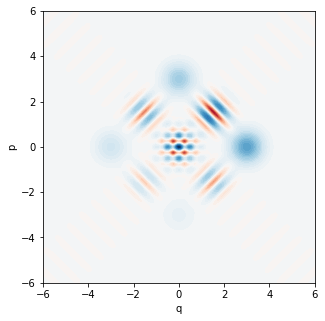

In [8]:
#@title 
#@markdown Circle radius (or amplitude of each coherent state) $\alpha$: 
alpha = 3  #@param {type:"number"}
#@markdown Coefficient list $\mathbf{c}=[c_1,\ldots,c_N]$, where number of components $N = \text{len}(\mathbf{c})$: 
ca = [1.0, 1.5, 2.0, 2.5] #@param
ca = np.roll(ca,1)
#@markdown Range of plot:
x_max = 6 #@param

# Calculate covariance, mean and coefficient 
N = len(ca)
omega = np.array([np.exp(-2j*np.pi*b/N) for b in range(N)],dtype='complex128') 
covN, meanN, cN = psi_bosonic(ca,omega,alpha)

# Simulate state
prog_bosonic = sf.Program(1)
with prog_bosonic.context as q:
    sf.ops.Bosonic(cN, meanN/sf.hbar, covN/sf.hbar**2) | q
eng = sf.Engine("bosonic")
state = eng.run(prog_bosonic).state

# Plot wigner function
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
plot_wigner(state, ax, x_max, findmarg=False, findqmax=False)

## Simulation of $|😺_{N,\beta}\rangle$

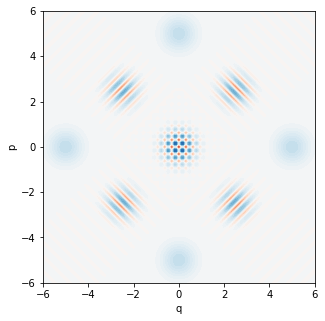

In [10]:
#@markdown Circle radius (or amplitude of each coherent state) $\beta$: 
beta = 5 #@param {type:"number"}
#@markdown Number of components/coherent states $N$: 
N = 4 #@param {type:"integer"}
#@markdown Range of plot:
x_max = 6 #@param

# Calculate covariance, mean and coefficient 
covN, meanN, cN = cat_bosonic(N,beta)

# Simulate state
prog_bosonic = sf.Program(1)
with prog_bosonic.context as q:
    sf.ops.Bosonic(cN, meanN/sf.hbar, covN/sf.hbar**2) | q
eng = sf.Engine("bosonic")
state = eng.run(prog_bosonic).state

# Plot 
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
plot_wigner(state, ax, x_max, findmarg=False, findqmax=False)

# Fock basis simulation

Note in this section we use the Fock basis, which must be limited to some maximum Fock cutoff. This introduces some numerical imperfections to the results, which can be minimal in low energy parameter regimes. 

## Teleamplifier process

Success probability = 0.12214
Fidelity compared with ideal = 0.99998


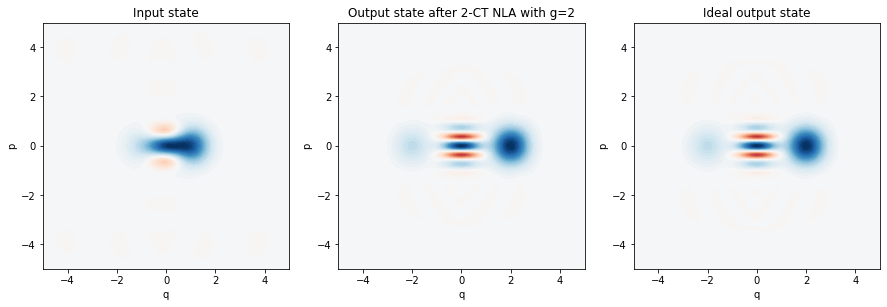

In [16]:
#@markdown Coefficient list $\mathbf{c}=[c_1,\ldots,c_N]$, where number of components $N = \text{len}(\mathbf{c})$: 
ca = [1.0, 2.0] #@param {type:"raw"}
ca = np.roll(ca,1)
#@markdown Circle radius (or amplitude of each coherent state) $\alpha$: 
alpha =  1#@param {type:"number"}
#@markdown Amount of amplification:
g =  2#@param {type:"number"} 
#@markdown Simulate up to a maximum Fock cutoff:
cutoff =  15#@param {type:"integer"} 
#@markdown Range of plot:
x_max = 5 #@param {type:"integer"} 

ca = np.array(ca,dtype='complex128')
fig = plt.figure(figsize=(5*3, 5)) # output figure
psi = psi_fock(ca,alpha,cutoff) # input state
N = len(ca) # number of cat nodes
theta = np.math.atan(1/g) # beam-splitter transmissivity 
cat = cat_fock(N,alpha*np.sqrt(1+g**2),cutoff) # state resource
S = QFT_matrix(N) # scattering matrix for N-splitter

# 1. Plot input
prog = sf.Program(1) # strawberry fields program
with prog.context as q:
  sf.ops.Ket(psi) | q # Alice input
eng = sf.Engine("tf", backend_options={"cutoff_dim": cutoff}) # initialise 
state = eng.run(prog).state
ax = fig.add_subplot(1,3,1)
plot_wigner(state, ax, x_max)
ax.set_title("Input state".format(N,g))

# 2. Run and get output probability
prog = sf.Program(N+1)
with prog.context as q:
  sf.ops.Ket(psi) | q[2] # Alice input
  sf.ops.Ket(cat) | q[0] # Bob cat resource input 
  sf.ops.BSgate(theta,np.pi) | (q[0],q[1]) # Configurable beam-splitter 
  sf.ops.Interferometer(S) | tuple(q[i] for i in range(1,N+1)) # N-splitter
eng = sf.Engine("tf", backend_options={"cutoff_dim": cutoff}) # initialise 
state = eng.run(prog, modes=[j for j in range(1,N+1)]).state
print("Success probability = {:.5}".format(state.fock_prob([0]+(N-1)*[1])))

# 3. Post-select and generate output state
prog = sf.Program(N+1)
with prog.context as q:
  sf.ops.Ket(psi) | q[2] # Alice input
  sf.ops.Ket(cat) | q[0] # Bob cat resource input 
  sf.ops.BSgate(theta,np.pi) | (q[0],q[1]) # Configurable beam-splitter 
  sf.ops.Interferometer(S) | tuple(q[i] for i in range(1,N+1)) # N-splitter
  sf.ops.MeasureFock(select=0) | q[1]  
  for i in range(2,N+1):
    sf.ops.MeasureFock(select=1) | q[i]   
eng = sf.Engine("tf", backend_options={"cutoff_dim": cutoff}) # initialise 
state = eng.run(prog, modes=[0]).state
ax = fig.add_subplot(1,3,2)
plot_wigner(state, ax, x_max)
ax.set_title("Output state after {}-CT NLA with g={}".format(N,g))

# 4. Ideal output state
gpsi = psi_fock(ca,g*alpha,cutoff) # output state
prog = sf.Program(1) # strawberry fields program
with prog.context as q:
  sf.ops.Ket(gpsi) | q # Alice input
eng = sf.Engine("tf", backend_options={"cutoff_dim": cutoff}) # initialise 
state = eng.run(prog).state
ax = fig.add_subplot(1,3,3)
plot_wigner(state, ax, x_max)
ax.set_title("Ideal output state")
print("Fidelity compared with ideal = {:.5}".format(state.fidelity(gpsi,0)))

## Entanglement distillation of TMSV

### With $N$-CT

In [ ]:
#@markdown Calculate the amount of GEOF

#@markdown Initial amount of squeezing $\chi$: 
r = 0.25 #@param {type:"number"}
#@markdown Transmissivity of the loss channel $\eta$: 
tl = 0.05 #@param {type:"number"}
Narr = [2,3]
garr = np.linspace(0.01,4)
barr = np.linspace(0.01,0.5,20) # beta cat resource
parr = np.zeros((len(Narr),len(garr),len(barr)))
geofarr = np.zeros((len(Narr),len(garr),len(barr)))

for Ni, N in enumerate(Narr):
  cutoff = N+1 # fock state cut-off
  S = QFT_matrix(N) # scattering matrix for N-splitter  
  for gi, g in enumerate(garr):     
    theta = np.math.atan(1/g)
    for bi, b in enumerate(barr): 
      cat = cat_fock(N,b,cutoff) # state resource
      # Run program success probability
      prog = sf.Program(N+2)
      with prog.context as q:
        sf.ops.S2gate(r=r) | (q[2],q[N+1]) # Alice input
        sf.ops.Ket(cat) | q[0] # Bob fock resource input 
        sf.ops.BSgate(theta,np.pi) | (q[0],q[1])
        sf.ops.LossChannel(np.sqrt(tl)) | q[1] # Loss at Bob
        sf.ops.LossChannel(np.sqrt(tl)) | q[2] # Loss channel at Alice
        sf.ops.Interferometer(S) | tuple(q[i] for i in range(1,N+1))

      eng = sf.Engine("tf", backend_options={"cutoff_dim": cutoff})
      state = eng.run(prog, modes=[j for j in range(1,N+1)]).state
      parr[Ni,gi,bi] = N*state.fock_prob([0]+(N-1)*[1]).numpy()

      # Run program GEOF
      prog = sf.Program(N+2)
      with prog.context as q:
        sf.ops.S2gate(r=r) | (q[2],q[N+1]) # Alice input
        sf.ops.Ket(cat) | q[0] # Bob fock resource input 
        sf.ops.BSgate(theta,np.pi) | (q[0],q[1])
        sf.ops.LossChannel(np.sqrt(tl)) | q[1] # Loss at Bob
        sf.ops.LossChannel(np.sqrt(tl)) | q[2] # Loss channel at Alice
        sf.ops.Interferometer(S) | tuple(q[i] for i in range(1,N+1))
        sf.ops.MeasureFock(select=0) | q[1]  
        for i in range(2,N+1):
            sf.ops.MeasureFock(select=1) | q[i]   

      eng = sf.Engine("tf", backend_options={"cutoff_dim": cutoff})
      state = eng.run(prog, modes=[0,N+1]).state

      mean, cov = dm2moments(state.dm())
      a, b, c1, c2 = cov[0,0], cov[2,2], cov[0,2], cov[1,3]
      geofarr[Ni,gi,bi] = GEOF(a,b,c1,c2)

# Find optimal resource amplitude
geofmaxi = np.argmax(geofarr,axis=2)
geofarrm = np.zeros((len(Narr),len(garr)))
parrm = np.zeros((len(Narr),len(garr)))
for Ni in range(len(Narr)):
  for gi in range(len(garr)):  
    geofarrm[Ni,gi] = geofarr[Ni,gi,geofmaxi[Ni,gi]]
    parrm[Ni,gi] = parr[Ni,gi,geofmaxi[Ni,gi]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


In [17]:
#@markdown Save/Load data

#@markdown Save (warning: overwrites previous data)? 
save_data = False #@param {type:"boolean"}
data_path = file_path+'/data'

if save_data:
  print("Will save garr, geofarrm, and parrm to {} as csv.".format(data_path))
  input("Press Enter to continue...")
  np.savetxt(data_path+'/garr.csv', garr, delimiter=',')
  np.savetxt(data_path+'/geofarrm.csv', geofarrm, delimiter=',')
  np.savetxt(data_path+'/parrm.csv', parrm, delimiter=',')
else: 
  print("Will load garr.csv, geofarrm.csv, and parrm.csv from {}".format(data_path))
  input("Press Enter to continue...")
  garr = np.loadtxt(data_path+'/garr.csv', delimiter=',')
  geofarrm = np.loadtxt(data_path+'/geofarrm.csv', delimiter=',')
  parrm = np.loadtxt(data_path+'/parrm.csv', delimiter=',')

Will load garr.csv, geofarrm.csv, and parrm.csv from /content/drive/MyDrive/research/2022-06-cat-amp/data
Press Enter to continue...


### With $N$-CT and experimental imperfections

In [14]:
#@markdown Calculate the amount of GEOF

#@markdown Initial amount of squeezing $\chi$: 
r = 0.25 #@param {type:"number"}
#@markdown Transmissivity of the loss channel $\eta$: 
tl = 0.05 #@param {type:"number"}
Narr = [2,3]
garr = np.linspace(0.01,4)
barr = np.linspace(0.01,0.5,20) # beta cat resource
parr = np.zeros((len(Narr),len(garr),len(barr)))
geofarr = np.zeros((len(Narr),len(garr),len(barr)))

#@markdown Transmissivity imperfection on resource state: 
ts = 0.7 #@param {type:"number"}
#@markdown Transmissivity imperfection on detectors: 
td = 0.7 #@param {type:"number"}

for Ni, N in enumerate(Narr):
  cutoff = N+1 # fock state cut-off
  S = QFT_matrix(N) # scattering matrix for N-splitter  
  for gi, g in enumerate(garr):     
    theta = np.math.atan(1/g)
    for bi, b in enumerate(barr): 
      cat = cat_fock(N,b,cutoff) # state resource
      # Run program success probability
      prog = sf.Program(N+2)
      with prog.context as q:
        sf.ops.S2gate(r=r) | (q[2],q[N+1]) # Alice input
        sf.ops.Ket(cat) | q[0] # Bob fock resource input 
        sf.ops.LossChannel(ts) | q[0]
        sf.ops.BSgate(theta,np.pi) | (q[0],q[1])
        sf.ops.LossChannel(np.sqrt(tl)) | q[1] # Loss at Bob
        sf.ops.LossChannel(np.sqrt(tl)) | q[2] # Loss channel at Alice
        sf.ops.Interferometer(S) | tuple(q[i] for i in range(1,N+1))
        for i in range(1,N+1):
          sf.ops.LossChannel(td) | q[i]        

      eng = sf.Engine("tf", backend_options={"cutoff_dim": cutoff})
      state = eng.run(prog, modes=[j for j in range(1,N+1)]).state
      parr[Ni,gi,bi] = N*state.fock_prob([0]+(N-1)*[1]).numpy()

      # Run program GEOF
      prog = sf.Program(N+2)
      with prog.context as q:
        sf.ops.S2gate(r=r) | (q[2],q[N+1]) # Alice input
        sf.ops.Ket(cat) | q[0] # Bob fock resource input 
        sf.ops.LossChannel(ts) | q[0]
        sf.ops.BSgate(theta,np.pi) | (q[0],q[1])
        sf.ops.LossChannel(np.sqrt(tl)) | q[1] # Loss at Bob
        sf.ops.LossChannel(np.sqrt(tl)) | q[2] # Loss channel at Alice
        sf.ops.Interferometer(S) | tuple(q[i] for i in range(1,N+1))
        for i in range(1,N+1):
          sf.ops.LossChannel(td) | q[i]   
        sf.ops.MeasureFock(select=0) | q[1]  
        for i in range(2,N+1):
          sf.ops.MeasureFock(select=1) | q[i]   

      eng = sf.Engine("tf", backend_options={"cutoff_dim": cutoff})
      state = eng.run(prog, modes=[0,N+1]).state

      mean, cov = dm2moments(state.dm())
      a, b, c1, c2 = cov[0,0], cov[2,2], cov[0,2], cov[1,3]
      geofarr[Ni,gi,bi] = GEOF(a,b,c1,c2)

# Find optimal resource amplitude
geofmaxi = np.argmax(geofarr,axis=2)
geofarrm_imp = np.zeros((len(Narr),len(garr)))
parrm_imp = np.zeros((len(Narr),len(garr)))
for Ni in range(len(Narr)):
  for gi in range(len(garr)):  
    geofarrm_imp[Ni,gi] = geofarr[Ni,gi,geofmaxi[Ni,gi]]
    parrm_imp[Ni,gi] = parr[Ni,gi,geofmaxi[Ni,gi]]
garr_imp = garr


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


In [18]:
#@markdown Save/Load data

#@markdown Save (warning: overwrites previous data)? 
save_data = False #@param {type:"boolean"}
data_path = file_path+'/data'

if save_data:
  print("Will save garr_imp, geofarrm_imp, and parrm_imp to {} as csv.".format(data_path))
  input("Press Enter to continue...")
  np.savetxt(data_path+'/garr_imp.csv', garr_imp, delimiter=',')
  np.savetxt(data_path+'/geofarrm_imp.csv', geofarrm_imp, delimiter=',')
  np.savetxt(data_path+'/parrm_imp.csv', parrm_imp, delimiter=',')
else: 
  print("Will load garr_imp.csv, geofarrm_imp.csv, and parrm_imp.csv from {}".format(data_path))
  input("Press Enter to continue...")
  garr_imp = np.loadtxt(data_path+'/garr_imp.csv', delimiter=',')
  geofarrm_imp = np.loadtxt(data_path+'/geofarrm_imp.csv', delimiter=',')
  parrm_imp = np.loadtxt(data_path+'/parrm_imp.csv', delimiter=',')

Will load garr_imp.csv, geofarrm_imp.csv, and parrm_imp.csv from /content/drive/MyDrive/research/2022-06-cat-amp/data
Press Enter to continue...


### Without $N$-CT

In [31]:
#@markdown Calculate GEOF of just loss channel and deterministic bound:
def covnQS(chiv,etav):
  av = 1+2*chiv**2/(1-chiv**2)
  bv = 1+2*etav*chiv**2/(1-chiv**2)
  cv = 2*np.sqrt(etav)*chiv/(1-chiv**2)
  return [av,bv,cv] 

#@markdown Initial amount of squeezing $\chi$: 
r = 0.25 #@param {type:"number"}
#@markdown Transmissivity of the loss channel $\eta$: 
tl = 0.05 #@param {type:"number"}

# No NLA 
cm2 = covnQS(r,tl)
geofnoNLA = GEOF(cm2[0],cm2[1],cm2[2],-cm2[2])
print("Fidelity = {:.3f}".format(geofnoNLA))

# No NLA Infinite Squeezing - deterministic bound
cm2 = covnQS(0.999999,tl)
geofdetbound = GEOF(cm2[0],cm2[1],cm2[2],-cm2[2])
print("Fidelity with infinite squeezing = {:.3f}".format(geofdetbound))

# No loss
cm2 = covnQS(r,1)
geofnoloss = GEOF(cm2[0],cm2[1],cm2[2],-cm2[2])
print("Fidelity with no loss = {:.3f}".format(geofnoloss))

Fidelity = 0.031
Fidelity with infinite squeezing = 0.301
Fidelity with no loss = 0.360


### Plot above generated data

In [ ]:
#@markdown Install and change to LaTeX style: 
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern'],
    'font.size': 9,
    'text.latex.preamble': r'\usepackage{amsfonts}'})
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

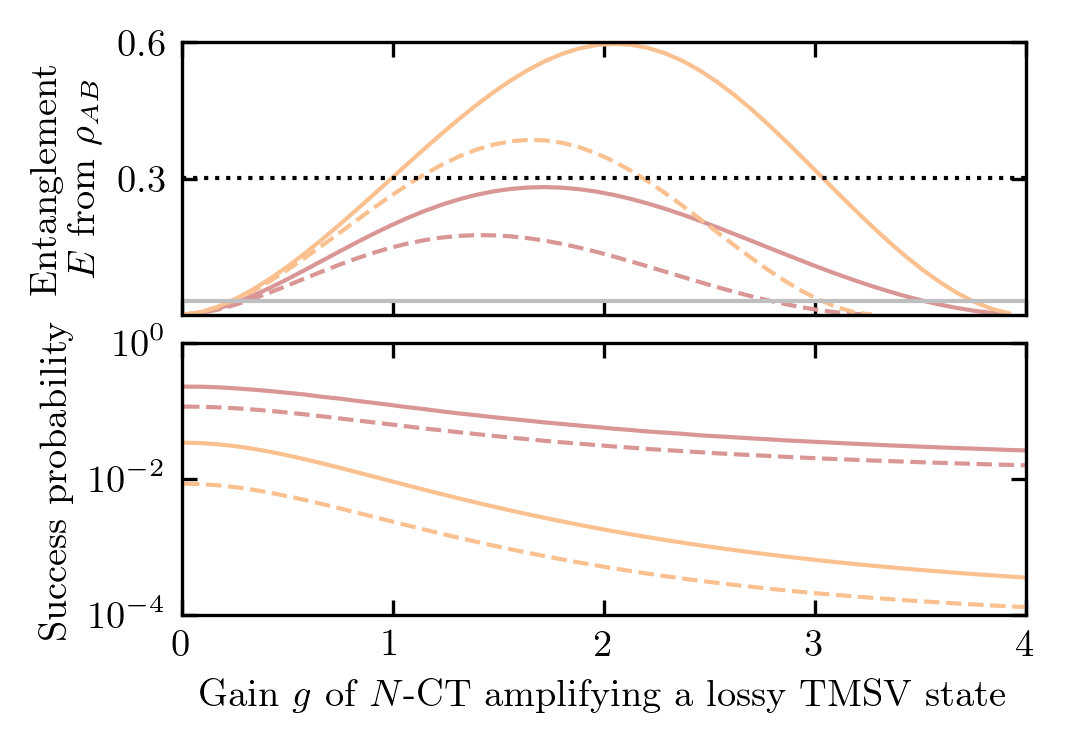

In [38]:
#@markdown Plot the data: 

# Font Style
# Colours 
red = (217/255, 150/255, 148/255) 
ora = (250/255, 192/255, 143/255)
yel = (240/255, 240/255, 150/255) 
gre = (195/255, 214/255, 155/255)
blu = (149/255, 179/255, 215/255) 
pur = (178/255, 162/255, 199/255)
gra = (191/255, 191/255, 191/255)
col = [red,ora,gre,blu,pur] # Color array
lw = 1

fig = mpl.pyplot.figure(figsize=(3.38583,3.38583), dpi=300)
axgeof = fig.add_subplot(3,1,1)
axprob = fig.add_subplot(3,1,2)
#axprob = fig.add_subplot(3,1,3)
for Ni in range(len(geofarrm)):
  axgeof.plot(garr,geofarrm[Ni,:],color=col[Ni],linewidth=lw)
  axprob.plot(garr,parrm[Ni,:],color=col[Ni],linewidth=lw)
  axgeof.plot(garr_imp,geofarrm_imp[Ni,:],'--',color=col[Ni],linewidth=lw)
  axprob.plot(garr_imp,parrm_imp[Ni,:],'--',color=col[Ni],linewidth=lw)
axgeof.axhline(geofnoNLA,color=gra,linewidth=lw)
axgeof.axhline(geofdetbound,linestyle=":",color='k',linewidth=lw)

axgeof.set_xlim(0,4)
axgeof.set_xticks([0,1,2,3,4])
axgeof.set_ylim(0,0.60)
axgeof.set_yticks([0.3,0.6])

axprob.set_xlim(0,4)
axprob.set_xticks([0,1,2,3,4])
axprob.set_ylim(10**-4,10**0)
axprob.set_yscale('log')
axprob.set_yticks([10**-4,10**-2,10**-0])

axgeof.set_ylabel('Entanglement\n$E$ from $\\rho_{AB}$') 
axprob.set_ylabel('Success probability') 
axprob.set_xlabel('Gain $g$ of $N$-CT amplifying a lossy TMSV state') 

axgeof.tick_params(direction='in',right='on',top='on',labelbottom=False)
axprob.tick_params(direction='in',right='on',top='on')

# axgeof.text(0.1, 0.6,'(a)')
# axprob.text(0.1, 4*10**-4,'(b)')
# axgeof.text(1.2, 0.05,'$N=0$',color=gra)
# axgeof.text(1.5, 0.2,'$N=2$',color=red)
# axgeof.text(1.8, 0.45,'$N=3$',color=ora)
# axgeof.text(3.95, 0.23,'Determin.\nbound',horizontalalignment='right')

plt.subplots_adjust(hspace = 0.105, wspace = 0.07, right = 0.985, left = 0.154, top = 0.975, bottom = 0.115)
# plt.savefig(file_path+'/figures/eofpvsg.png',dpi=300)